# 简单理解 Grover 算法求解数独问题

> 创建时间：2023-02-19

:::{danger}

本文档作者有学习、但并非量子计算相关专业工作者。本文档可能在可观描述上存在不合规范或过时的情况、且主观描述有错误的可能性。

:::

:::{note}

文档有较多折叠代码。这些折叠代码可能用于展示图片、定义数独问题、或是比较琐碎的用于经典计算机上的处理程序。

:::

数独是老少皆宜的益智游戏。在 **【(日本) 东北大学加龄医学研究所 川岛隆太博士监修 大人的脑部锻炼】** 中指出，数独

- **可能** 有助于前额叶的活性化；
- **可能** 有助于提高记忆力。

> 你们有见过这么长名字的游戏么 hhh =ω= (尽管上边不是简中正式游戏名称)
>
> 原来有了博士的头衔就可以光明正大地监修游戏了呀。做游戏也是康庄大道。冲！

其规则很简单：在下述 $9 \times 9$ 的格子中填入数字，使得

- 任意行格子数字不重复、
- 任意列格子数字不重复、
- 任意宫格子 (粗线画出的 $3 \times 3$ 的大宫格内) 数字不重复。

原则上，**量子的 Grover 算法可以平方倍地加速** 数独问题的求解 (但也仅限于原则上)。在这篇文档中，我们将会了解数独问题在 Grover 算法下的实现过程。

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

import sudokutools
from sudokutools.sudoku import Sudoku
import sudokutools.sudoku
import sudokutools.solve
import sudokutools.generate

import qiskit
from qiskit import (
    QuantumCircuit, QuantumRegister, ClassicalRegister,
    Aer, transpile, assemble)
from qiskit.quantum_info import Statevector

import sys
import numpy as np
import itertools

set_matplotlib_formats("svg")

In [3]:
mpl.rcParams['font.sans-serif'] = "FreeSans"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

In [4]:
def plot_puzzle_3x3(puzzle, ax=None, original=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-0.05, 9.05)
    ax.set_ylim(-9.05, 0.05)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_yticks([])

    sudokutools.solve.init_candidates(puzzle)

    d3 = 1/3
    cand_shift = {
        1: (-d3, d3), 2: (0, d3), 3: (d3, d3),
        4: (-d3, 0), 5: (0, 0), 6: (d3, 0),
        7: (-d3, -d3), 8: (0, -d3), 9: (d3, -d3),
    }

    for i in range(0, 10):
        linewidth = 1.75 if i % 3 == 0 else 0.75
        ax.plot([i, i], [0, -9], color="black", linewidth=linewidth)
        ax.plot([0, 9], [-i, -i], color="black", linewidth=linewidth)
    for i in range(9):
        for j in range(9):
            val = puzzle.get_number(j, i)
            color = "black"
            if original is not None:
                if val != original.get_number(j, i):
                    color = "C0"
            if val != 0:
                ax.text(
                    i + 0.5, -j - 0.5, val,
                    ha="center", va="center", size=24, color=color)
            else:
                cand = puzzle.get_candidates(j, i)
                for k in cand:
                    ax.text(
                        i + 0.5 + cand_shift[k][0], -j - 0.5 + cand_shift[k][1], k,
                        ha="center", va="center", size=10, color="gray")

In [5]:
def plot_puzzle_2x2(puzzle, ax=None, original=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.set_xlim(-0.05, 4.05)
    ax.set_ylim(-4.05, 0.05)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_yticks([])

    sudokutools.solve.init_candidates(puzzle)

    cand_shift = {
        1: (-0.25, 0.25),
        2: (0.25, 0.25),
        3: (-0.25, -0.25),
        4: (0.25, -0.25)
    }

    for i in range(0, 5):
        linewidth = 1.75 if i % 2 == 0 else 0.75
        ax.plot([i, i], [0, -4], color="black", linewidth=linewidth)
        ax.plot([0, 4], [-i, -i], color="black", linewidth=linewidth)
    for i in range(4):
        for j in range(4):
            val = puzzle.get_number(j, i)
            color = "black"
            if original is not None:
                if val != original.get_number(j, i):
                    color = "C0"
            if val != 0:
                ax.text(
                    i + 0.5, -j - 0.5, val,
                    ha="center", va="center", size=24, color=color)
            else:
                cand = puzzle.get_candidates(j, i)
                for k in cand:
                    ax.text(
                        i + 0.5 + cand_shift[k][0], -j - 0.5 + cand_shift[k][1], k,
                        ha="center", va="center", size=13, color="gray")

下面是一个 (其实不太) 常见的数独的问题与答案[^HardestSudoku] (你可以试着在各种平台[^sudokuwiki]或软件[^SunnieShine]试一下解决这个数独 hhh 我反正弃疗了)：

[^HardestSudoku]: [Stack Exchange: How do I solve the world's hardest sudoku](https://puzzling.stackexchange.com/questions/252/how-do-i-solve-the-worlds-hardest-sudoku)

[^sudokuwiki]: [SudokuWiki.org](https://www.sudokuwiki.org/sudoku.htm)

[^SunnieShine]: [Github: SunnieShine/Sudoku](https://github.com/SunnieShine/Sudoku/releases/tag/v0.12)

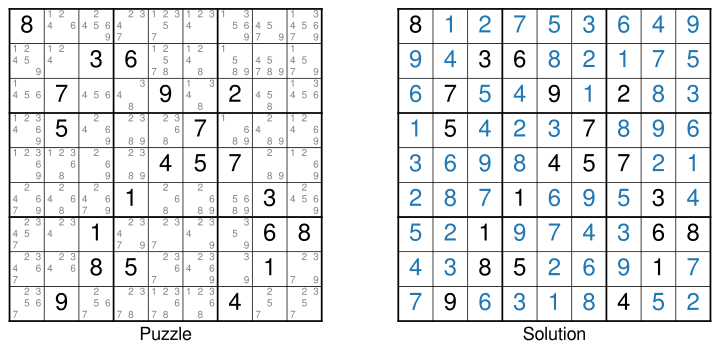

In [6]:
puzzle_3x3_example = sudokutools.sudoku.Sudoku.decode("""
8........
..36.....
.7..9.2..
.5...7...
....457..
...1...3.
..1....68
..85...1.
.9....4..""".replace(".", "0"))
solution_3x3_example = next(sudokutools.solve.dlx(puzzle_3x3_example))
fig, axs = plt.subplots(ncols=2, figsize=(11, 5))
plot_puzzle_3x3(puzzle_3x3_example, axs[0])
plot_puzzle_3x3(solution_3x3_example, axs[1], original=puzzle_3x3_example)
axs[0].set_xlabel("Puzzle", fontsize=18)
axs[1].set_xlabel("Solution", fontsize=18)
fig.tight_layout()

我们将借用作为 Python 的数独库 sudokutools 的一些很简单的功能。文档主体的量子线路与绘制由 Qiskit 完成。

## 符号定义

对于阶为 $(n, m)$ 的方形数独，其数独阵的横向、纵向格子数为 $n \times m$，总格子数为 $n^2 \times m^2$。若 $m = n$，那么我们简称 $(n, m)$ 阶数独为 $n$ 阶数独。需要留意，在我们的定义中，随着阶数 $n$ 的增加，数独方阵是 $n^4$ 大小的。

对于一个数独谜题，有待解决的空缺格子数定义为 $n_\mathrm{empty}$。

我们平时见到最多的数独是 $n = 3$ 阶数独，其布局是 $9 \times 9$ 的方阵。而在这篇文档中，我们主要将讨论较为简单的情形，$n = 2$ 阶数独，即布局是 $4 \times 4$ 的方阵。我们可以允许数独是多解的 (一般的解数独软件和解法分析中，是不允许多解情况存在的)。

大部分时候，我们将会讨论下述两个数独问题。

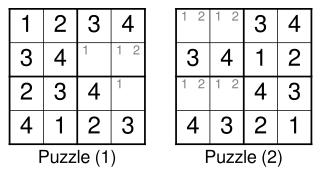

In [7]:
puzzle1 = sudokutools.sudoku.Sudoku.decode("1234340023404123")
puzzle2 = sudokutools.sudoku.Sudoku.decode("0034341200434321")
sudokutools.solve.init_candidates(puzzle1)
sudokutools.solve.init_candidates(puzzle2)

fig, axs = plt.subplots(ncols=2, figsize=(5.5, 2.7))
plot_puzzle_2x2(puzzle1, axs[0]); plot_puzzle_2x2(puzzle2, axs[1])
axs[0].set_xlabel("Puzzle (1)", fontsize=18); axs[1].set_xlabel("Puzzle (2)", fontsize=18);

## 经典计算机上的预处理：遍历约束条件

不管是经典算法还是量子算法，为解决数独问题，首先要做的事情是如何验证结果的正确性。在数学上，数独可以看作是约束满足问题 (Constraint Satisfaction Problem)。这类问题可以通过给定所有的约束条件后，进行 (暴力) 搜索得到解。

以 Puzzle (1) 问题为例，首先我们规定记号 $V_x$ 为尚未被填入的格子的编号：

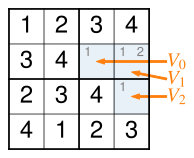

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.3))
plot_puzzle_2x2(puzzle1, ax)
ax.set_xlim(-0.05, 5)
ax.set_ylim(-4.05, 0.05)
for (i, j) in [(1, 2), (1, 3), (2, 3)]:
    ax.fill_between([j, j+1], [-i, -i], [-i-1, -i-1], color="C0", alpha=0.1)
ax.arrow(4.5, -1.5, -2, 0, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -1.5, "$V_0$", ha="left", va="center", size=20, color="C1")
ax.arrow(4.5, -2, -1, 0.2, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -2, "$V_1$", ha="left", va="center", size=20, color="C1")
ax.arrow(4.5, -2.5, -1, 0, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -2.5, "$V_2$", ha="left", va="center", size=20, color="C1")
fig.tight_layout()

我们回顾过，数独的所有限制条件就是行、列、宫的格子分别互不相等。对于上述 Puzzle (1) 的 $V_i \ (i = 0, 1, 2)$，所需要满足的条件有两类：

- 与已知格子的关系。

    譬如对于 $V_0$，其分析如下图所示。由于行不能取值 3、4，列不能取值 3、4、2，宫不能取值 3、4。因此总地来看，$V_0$ 不可取数值为 2、3、4，可取数值为 1。
    
    事实上，每个格子的可取数值，已经在图中以灰色数字标识了。在量子计算的 Grover 算法设计上，我们更倾向于说一个格子的不可取值数是多少。对于 Puzzle (1)，列举如下：
    
    - $V_0 \not \in \{2, 3, 4\}$，
    - $V_1 \not \in \{3, 4\}$，
    - $V_2 \not \in \{2, 3, 4\}$，

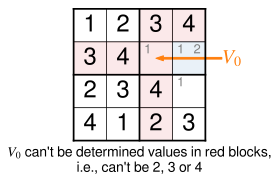

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.6))
for (i, j) in [(1, 0), (1, 1), (1, 2), (0, 2), (0, 3), (2, 2), (3, 2)]:
    ax.fill_between([j, j+1], [-i, -i], [-i-1, -i-1], color="C3", alpha=0.1)
for (i, j) in [(1, 3)]:
    ax.fill_between([j, j+1], [-i, -i], [-i-1, -i-1], color="C0", alpha=0.1)
plot_puzzle_2x2(puzzle1, ax)
ax.set_xlim(-1, 5)
ax.arrow(4.5, -1.5, -2, 0.0, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -1.5, "$V_0$", ha="left", va="center", size=20, color="C1")
ax.set_xlabel("$V_0$ can't be determined values in red blocks,\n"
              "i.e., can't be 2, 3 or 4", fontsize=14)
fig.tight_layout()

- 与未知格子的关系。

    譬如对于 $V_0$，它与 $V_1$ 处在同一行或宫内；因此 $V_0$ 与 $V_1$ 的数值不能相等。但 $V_0$ 与 $V_2$ 不处于相同的行、列或宫，是可以相等的。
    
    对于 Puzzle (1)，列举如下：
    
    - $V_0 \neq V_1$，$V_1 \neq V_2$。

我们现在需要做的就是要用程序的语言，将这些情况写出来。

- `get_empty_grids` 给出当前的空格行列位置，并对每个空格 $V_x$ 标记 $x$ 的数值作为 dict 的 key。需要注意，由于 Python 是 0-index 的语言，因此我们通常说的“第一行”在这里是第 0 行；
- `get_cond_init_number` 给出每个 $V_x$ 所不能取的数值；
- `get_cond_edges` 给出未知格子 $V_x$ 与 $V_y \ (y > x)$ 之间，不能取相同值的情况。

这部分代码的定义在本文档中被折叠。对于 Puzzle (1)，其作用效果如下述代码块所示。

In [10]:
def get_empty_grids(puzzle):
    empty_grids = dict()
    n = 0
    for row, col in puzzle:
        if puzzle.get_number(row, col) == 0:
            empty_grids[n] = (row, col)
            n += 1
    return empty_grids

def get_cond_init_number(puzzle, max_number=-1):
    empty_grids = get_empty_grids(puzzle)
    cond_init_number = dict()
    for n, (row, col) in empty_grids.items():
        cond_init_number[n] = list(set(puzzle.numbers).difference(puzzle.get_candidates(row, col)))
    if max_number != -1:
        for n in cond_init_number:
            cond_init_number[n] += list(range(max(puzzle.numbers) + 1, max_number + 1))
    return cond_init_number

def get_cond_edges(puzzle):
    empty_grids = get_empty_grids(puzzle)
    empty_grids_list = sorted(empty_grids.items(), key=lambda v: v[0])
    cond_edges = dict()
    for n1, (row1, col1) in empty_grids_list:
        for n2, (row2, col2) in empty_grids_list[n1+1:]:
            if row1 == row2 or col1 == col2 or (row2, col2) in puzzle.box_of(row1, col1):
                if n1 not in cond_edges:
                    cond_edges[n1] = [n2]
                else:
                    cond_edges[n1].append(n2)
    return cond_edges

In [11]:
get_empty_grids(puzzle1)

{0: (1, 2), 1: (1, 3), 2: (2, 3)}

In [12]:
get_cond_init_number(puzzle1)

{0: [2, 3, 4], 1: [3, 4], 2: [2, 3, 4]}

In [13]:
get_cond_edges(puzzle1)

{0: [1], 1: [2]}

## Grover 算法简要回顾

Grover 算法已经有许多文档作了细致、甚至包括含代码的说明了[^qiskit_grover][^microsoft_grover][^pyqpanda_grover][^QCQI_grover]。这里最为推荐的材料是 Qiskit 的介绍[^qiskit_grover]。我就只对关键的问题作一些说明、以及明确这篇文档的符号定义。

[^qiskit_grover]: [Qiskit: Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)

[^microsoft_grover]: [Microsoft: Grover 搜索算法理论](https://learn.microsoft.com/zh-cn/azure/quantum/concepts-grovers)

[^pyqpanda_grover]: [pyQPanda: Grover算法和量子计数算法](https://pyqpanda-toturial.readthedocs.io/zh/latest/Grover.html)

[^QCQI_grover]: Nielsen, M. A.; Chuang, I. L. *Quantum Computation and Quantum Information (10th anniversary ed.)*, ch. 6; Cambridge University Press, 2010.

### 算法回顾 (1)：适用的情况与 Oracle 算符

Grover 算法的常见用途是 **搜索问题的解**。假设搜索问题可以定义为一个函数 $f(x)$，其中 $x$ 是待搜索的对象，且

$$
f(x) = \left\{
\begin{matrix}
0 & (x \text{ is not solution}) \\
1 & (x \text{ is solution})
\end{matrix}
\right.
$$

且 $f(x)$ 可以由较低的代价在量子计算机上实现，那么 Grover 算法可以用于这类问题。

以当前的数独问题 Puzzle (1) 为例，我们令 $x = (V_0, V_1, V_2)$。如果数独方阵上的空格满足约束条件，那么 $f(x) = 1$；否则 $f(x)$ 为零。

图像上的理解可以表现如下。当 $x = (V_0, V_1, V_2)$ 的取值是问题的解，即 $x = (1, 2, 1)$ 时，那么 $f(x) = 1$：

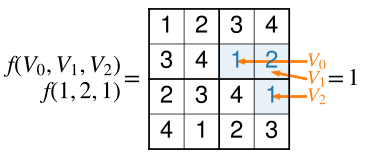

In [14]:
fig, ax = plt.subplots(figsize=(5, 2.3))
plot_puzzle_2x2(Sudoku.decode("1234341223414123"), ax, original=puzzle1)
ax.set_xlim(-0.05, 5)
ax.set_ylim(-4.05, 0.05)
for (i, j) in [(1, 2), (1, 3), (2, 3)]:
    ax.fill_between([j, j+1], [-i, -i], [-i-1, -i-1], color="C0", alpha=0.1)
ax.arrow(4.5, -1.5, -2, 0, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -1.5, "$V_0$", ha="left", va="center", size=20, color="C1")
ax.arrow(4.5, -2, -1, 0.2, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -2, "$V_1$", ha="left", va="center", size=20, color="C1")
ax.arrow(4.5, -2.5, -1, 0, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -2.5, "$V_2$", ha="left", va="center", size=20, color="C1")
ax.text(-0.8, -2, "$f(V_0, V_1, V_2)$\n$f(1, 2, 1)$",
        ha="right", va="center", size=24, color="black")
ax.text(-0.15, -2, "$=$",
        ha="right", va="center", size=24, color="black")
ax.text(5, -2, "$= 1$",
        ha="left", va="center", size=24, color="black")
fig.tight_layout()

但若我们没有给出正确的解时，那么函数 $f(x)$ 的值就是零了：

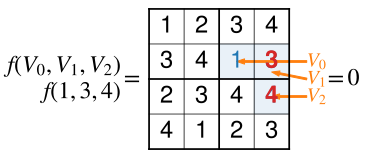

In [15]:
fig, ax = plt.subplots(figsize=(5, 2.3))
plot_puzzle_2x2(Sudoku.decode("1234341323444123"), ax, puzzle1)
ax.set_xlim(-0.05, 5)
ax.set_ylim(-4.05, 0.05)
for (i, j) in [(1, 2), (1, 3), (2, 3)]:
    ax.fill_between([j, j+1], [-i, -i], [-i-1, -i-1], color="C0", alpha=0.1)
ax.arrow(4.5, -1.5, -2, 0, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -1.5, "$V_0$", ha="left", va="center", size=20, color="C1")
ax.arrow(4.5, -2, -1, 0.2, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -2, "$V_1$", ha="left", va="center", size=20, color="C1")
ax.arrow(4.5, -2.5, -1, 0, width=0.05, color="C1", length_includes_head=True)
ax.text(4.5, -2.5, "$V_2$", ha="left", va="center", size=20, color="C1")
for i, j, val in [(1, 3, 3), (2, 3, 4)]:
    ax.text(j + 0.5, -i - 0.5, val,
            ha="center", va="center", size=24, color="C3", fontweight="bold")
ax.text(-0.8, -2, "$f(V_0, V_1, V_2)$\n$f(1, 3, 4)$",
        ha="right", va="center", size=24, color="black")
ax.text(-0.15, -2, "$=$",
        ha="right", va="center", size=24, color="black")
ax.text(5, -2, "$= 0$",
        ha="left", va="center", size=24, color="black")
fig.tight_layout()

因此，数独问题是可以通过一个抽象的函数 $f(x)$ 来定义的；剩下的问题就是这样的问题要如何套用到量子计算中。为此，我们必须要至少解决两个问题：

- 如何编码 $x$ 到量子比特 (Qubit，简称 QB <del>[丘比](https://zh.moegirl.org.cn/%E4%B8%98%E6%AF%94)</del>) 中，成为态 $| x \rangle$；
- 如何编码函数 $f(x)$ 成为量子门路；我们希望能编码出算符 $O$ (该算符也称为 Oracle)，使得 $O | x \rangle = (-1)^{f(x)} | x \rangle$。
    - 该问题即如何构造可以在量子门路中实现的算符 $O$，使得当 $| x \rangle$ 是问题的解时，$O | x \rangle = - | x \rangle$；否则若不是问题的解，则 $O | x \rangle = | x \rangle$。

一旦这两个问题可以解决，那么 Grover 算法就可以套用到这一类问题中了。我们将在后文讨论，如何用程序实现上述两个问题，而将数独问题系统地转化为量子计算机可解问题。

### 算法回顾 (2)：均衡叠加态、解态与非解态

这里需要一些基础数学上的回顾。我们大致参照 QCQI 教材的描述[^QCQI_grover]。

对于均衡叠加态 $| \psi \rangle$，可以将其拆分为非正确解态 $| \alpha \rangle$ 与正确解态 $| \beta \rangle$ 的线性组合：

$$
| \psi \rangle = \cos \frac{\theta}{2} | \alpha \rangle + \sin \frac{\theta}{2} | \beta \rangle \label{eq.1} \tag{1}
$$

:::{admonition} 对于上式作的一些补充说明
:class: dropdown

- 均衡叠加态是一个确定的量子态。对于 $r$ 个比特的情形，均衡叠加态是

    $$
    | \psi \rangle = \frac{1}{\sqrt{2^r}} \sum_{x = 0}^{2^r - 1} | x \rangle
    = \frac{1}{\sqrt{2^r}} \big( | 00 \ldots 00 \rangle + | 00 \ldots 01 \rangle + \cdots + | 11 \ldots 11 \rangle \big)
    $$
    
    对于 Puzzle (1)，如果我们用 $| x \rangle = | (V_0, V_1, V_2) \rangle$ 来表示所有情况，且每个 $V_0$ 使用 2 个量子比特编码，那么总共就需要 6 个量子比特对 $| x \rangle$ 进行编码；其均衡叠加态是
    
    $$
    | \psi \rangle = \frac{1}{\sqrt{2^6}} \big( | (1, 1, 1) \rangle + | (1, 1, 2) \rangle + \cdots + | (4, 4, 4) \rangle \big)
    $$

    我们要解的 2 阶数独，每个数可取值的情况数恰好 $4 = 2^2$，可以用 2 个量子比特编码；而对于 3 阶数独，如果将每个空格可取值数编码为 4 个量子比特，那么就需要注意 10~16 这些数是否要考虑入 $| \psi \rangle$。

- $| \alpha \rangle$ 与 $| \beta \rangle$ 是已经归一化的量子态；可以是叠加态。$\langle \alpha | \beta \rangle = 0$。譬如以 Puzzle (1) 而言，

    $$
    \begin{align*}
    | \beta \rangle &= | (1, 2, 1) \rangle \\
    | \alpha \rangle &= \frac{1}{\sqrt{2^6 - 1}} \big( | (1, 1, 1) \rangle + \cdots + | (4, 4, 4) \rangle \big) \quad \mathrm{without} \ | (1, 2, 1) \rangle
    \end{align*}
    $$
    
    对于 Puzzle (2) 而言，我们知道它有两种解，因此
    
    $$
    \begin{align*}
    | \beta \rangle &= \frac{1}{\sqrt{2}} \big( | (1, 2, 2, 1) \rangle + | (2, 1, 1, 2) \rangle \big) \\
    | \alpha \rangle &= \frac{1}{\sqrt{2^{8} - 1}} \big( | (1, 1, 1, 1) \rangle + \cdots + | (4, 4, 4, 4) \rangle \big) \quad \mathrm{without} \ | (1, 2, 2, 1) \rangle , \ | (2, 1, 1, 2) \rangle
    \end{align*}
    $$

:::

如果令所有的可能取值情况数为 $N$ (Puzzle (1) 总共是 $4^3 = 64$ 种、Puzzle (2) 总共是 $4^5 = 1024$ 种)；问题的解数量为 $M$ (Puzzle (1) 解数量为 1、Puzzle (2) 解数量为 2)，那么依据归一化条件，容易推知

$$
| \psi \rangle = \sqrt{\frac{N - M}{N}} | \alpha \rangle + \sqrt{\frac{M}{N}} | \beta \rangle \label{eq.2} \tag{2}
$$

联立 eq (1)，得到波函数的参数 $\theta = 2 \arcsin \sqrt{M / N}$。

### 算法回顾 (3)：Grover 算符与其表示矩阵

Grover 算法可以看作是一种对正确解态 $| \beta \rangle$ 的增幅器。

定义相移增幅算符 $U_s$ 与 Grover 算符 $G$ 为

$$
\begin{gather*}
U_s = 2 | \psi \rangle \langle \psi | - I \\
G = U_s O
\end{gather*}
$$

以 $| \alpha \rangle, | \beta \rangle$ 为基，我们可以表明，Grover 算符 $G$ 的矩阵表示是

$$
G =
\begin{pmatrix}
\cos \theta & - \sin \theta \\
\sin \theta & \cos \theta
\end{pmatrix}
$$

这事实上就是对 $| \alpha \rangle, | \beta \rangle$ 构成的向量的一种旋转作用。

:::{admonition} Grover 算符 $G$ 矩阵表示的导出
:class: dropdown

以 $| \alpha \rangle, | \beta \rangle$ 为基，我们先写分别写出 $O$ 与 $U_s$ 作用于这两个基的结果 (需要利用倍角公式)：

$$
\begin{align*}
O | \alpha \rangle &= | \alpha \rangle \\
O | \beta \rangle &= - | \beta \rangle
\end{align*}
$$

$$
\begin{align*}
U_s | \alpha \rangle &= 2 | \psi \rangle \langle \psi | \alpha \rangle - | \alpha \rangle = 2 \big( \cos \frac{\theta}{2} | \alpha \rangle + \sin \frac{\theta}{2} | \beta \rangle \big) \times \cos \frac{\theta}{2} - | \alpha \rangle \\
&= \cos \theta | \alpha \rangle + \sin \theta | \beta \rangle \\
U_s | \beta \rangle &= 2 | \psi \rangle \langle \psi | \beta \rangle - | \beta \rangle = 2 \big( \cos \frac{\theta}{2} | \alpha \rangle + \sin \frac{\theta}{2} | \beta \rangle \big) \times \sin \frac{\theta}{2} - | \alpha \rangle \\
&= \sin \theta | \alpha \rangle - \cos \theta | \beta \rangle
\end{align*}
$$

由此可得

$$
U_s =
\begin{pmatrix}
\cos \theta & \sin \theta \\
\sin \theta & - \cos \theta
\end{pmatrix}, \;
O = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

将这两个矩阵表示相乘，就得到 $G = U_s O$ 的矩阵表示了。

:::

多次使用这种旋转作用，就可以对正确解的态 $| \beta \rangle$ 进行增幅放大。具体来说，如果给定下述量子态 ($\gamma$ 是任意角度)

$$
| \varphi \rangle = \cos \gamma | \alpha \rangle + \sin \gamma | \beta \rangle
$$

那么将 Grover 算符 $G$ 作用于该态，并根据和差化积公式，可以得到

$$
\begin{align*}
G | \varphi \rangle &= \big( \cos \theta \cos \gamma - \sin \theta \sin \gamma \big) | \alpha \rangle + \big( \sin \theta \cos \gamma + \cos \theta \sin \gamma \big) | \beta \rangle \\
&= \cos (\gamma + \theta) | \alpha \rangle + \sin (\gamma + \theta) | \beta \rangle
\end{align*}
$$

以此类推，可以立即得到

$$
G^k | \varphi \rangle = \cos (\gamma + k \theta) | \alpha \rangle + \sin (\gamma + k \theta) | \beta \rangle
$$

因此直观地来说，每次作用 Grover 算符 $G$ 就增加 $| \beta \rangle$ 出现在量子态中的概率。如果能选取一个合适的 $k$，使得 $\gamma + k \theta \simeq \pi / 2$，那么此时 $G^k | \varphi \rangle \simeq | \beta \rangle$。这也就是所谓 Grover 算符 $G$ 是正确解态的增幅放大器的意思了。

特别地，如果我们取 $| \varphi \rangle = | \psi \rangle$ (之所以这样取量子态，是因为 $| \psi \rangle$ 很容易由量子门路构造)，那么

$$
G^k | \psi \rangle = \cos \left( \frac{2 k + 1}{2} \theta \right) | \alpha \rangle + \sin \left( \frac{2 k + 1}{2} \theta \right) | \beta \rangle
$$

回顾到 $\theta = 2 \arcsin \sqrt{M / N}$ (假设 $M \ll N$)，其中 $N$, $M$ 分别是可能的取值数、与解个数。当 Grover 算符作用次数是下述值时，

$$
k = \frac{\pi}{4 \arcsin \sqrt{M / N}} - \frac{1}{2} \sim \frac{\pi}{4} \sqrt{\frac{N}{M}} + o(\sqrt{M/N})
$$

我们就能近乎以 100% 的概率得到正确的解态 $| \beta \rangle$ 了。

## 构造数独问题的量子线路

### 对待定的格子的编码

以 Puzzle (1) 为例。这里考虑的是对于 $x = (V_0, V_1, V_2)$，如何将 $x$ 编码到量子比特上。

首先需要确认对每个格子需要的量子比特数量。对于 Puzzle (1)，一共允许的数字是 $1, 2, 3, 4$ 共 4 个，因此编码一个数字所需要的量子比特数 $n_\mathrm{qubit}$ 为

$$
n_\mathrm{qubit} = \lceil \log_2 (n^2) \rceil = 2
$$

In [16]:
def get_nqubit(puzzle):
    """
    Get number of qubits to encode a number in a Sudoku puzzle.
    puzzle: Sudoku puzzle instance
    """
    size = puzzle.size
    return int(np.ceil(np.log(size[0] * size[1]) / np.log(2)))

In [17]:
nqubit = get_nqubit(puzzle1)
nqubit

2

编码时，每个数字先减去 1 (因为通常的数独都是从 1 数起的)，随后进行二进制编码：

| 数字 | 编码 | 数字 | 编码 |
|-----|:----|-----|:----|
| 1 | 0 | 5 | 100 |
| 2 | 1 | 6 | 101 |
| 3 | 10 | 7 | 110 |
| 4 | 11 | 8 | 111 |

In [18]:
def encode_sudoku(num):
    """
    Encode a number with Sudoku numbering convention (starts from 1).
    Encoded binary represents num-1 in usual case.
    """
    return bin(num - 1)[2:]

In [19]:
encode_sudoku(7)

'110'

确定对单个数字的编码后，就可以考虑在量子门路中，写入编码多个数字、或测量多个数字的具体做法了。在 Puzzle (1) 中，对于每个数字需要 2 个编码、一共有 3 个待定格子，因此总共需要 6 个量子比特。这 6 个比特，依照待定格子，分配到待注册的工作比特 (work qubit) 的列表称为 `qb_w_list`；依照比特分配的列表称为 `qb_w_all`：

In [20]:
qb_w_list = [QuantumRegister(nqubit, name="w" + str(n)) for n in get_empty_grids(puzzle1).keys()]
qb_w_all = list(itertools.chain(*[qb_w_reg for qb_w_reg in qb_w_list]))

用类似的方法，我们定义 6 个传统比特 (注册这些比特的列表为 `cb_list`，依每个传统比特分配的列表为 `cb_all`)；它们用于将对 6 个量子比特进行测量：

In [21]:
cb_list = [ClassicalRegister(nqubit, name="cbit" + str(n)) for n in get_empty_grids(puzzle1).keys()]
cb_all = list(itertools.chain(*[cb_reg for cb_reg in cb_list]))

### 编码、量子线路、测量、解码

:::{admonition} 编码约定俗成

在这篇文档中，我们对二进制的编码使用 big-endian。在量子线路与输出中，我们遵循从上到下、从右到左的数字位数增大的约定俗成。但这个顺序与 Qiskit 的默认顺序经常是相反的。

:::

在量子计算机上，编码数字的方式是对一部分量子比特施加以 $X$ gate。这样的量子线路可以用下述函数 `apply_encode_xgate` 实现：

In [22]:
def apply_encode_xgate(qcirc, qb_reg, encode):
    """
    Apply X gates to quantum circuit by encoded binaries.
    qcirc: Quantum circuit instance
    qb_reg: Qubit register (or list of Qubits)
    encode: Encoded binary string
    """
    for i, val in enumerate(encode[::-1]):
        if val != "1": continue
        qcirc.x(qb_reg[i])
    return qcirc

譬如对于三个数字数独的三个数字 (3, 2, 4)，将这三个数字编码 (编码结果是 `10 01 11`)，并实现到量子线路并加以测量，可以写为

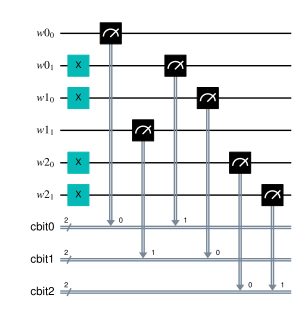

In [23]:
qcirc = QuantumCircuit()
qcirc.add_register(*qb_w_list, *cb_list)
for qb_w_reg, num in zip(qb_w_list, [3, 2, 4]):
    apply_encode_xgate(qcirc, qb_w_reg, encode_sudoku(num))
qcirc.measure(qb_w_all, cb_all)
qcirc.draw(scale=0.7)

对这样的线路，在量子计算模拟机上有两种做法。一种方法与实体量子计算机一样，就是对每个量子比特进行结果非 1 即 0 的测量。如果测量结果有多种可能，就需要重复进行多次测量，才能得到有统计意义的结果。

In [24]:
def get_result_prob_by_shots(qcirc, shots=100):
    simulator = Aer.get_backend("aer_simulator")
    qcirc_transpiled = transpile(qcirc, simulator)
    qobj = assemble(qcirc_transpiled)
    result = simulator.run(qobj, shots=shots).result()
    res_dict = result.get_counts()
    res_dict = {key[::-1].replace(" ", ""): val / shots for key, val in res_dict.items()}
    return res_dict

另一种“测量”方式是直接取线路执行到最后的量子态 (Statevector)。通过这种方法可以直接得到完整的统计结果，但它本质上并非是物理可实现的测量过程，因此只有理论上的价值。

In [25]:
def get_result_prob_by_statevector(qcirc, qb_list=None, tol=1e-3):
    """
    Get probabilities of measured results for given qubits by analyzing statevector
    qcirc: Quantum circuit
    qb_list: Qubits to be measured, default: all qubits to be measured 
    tol: Threshold of probabilities to represent result
    """
    if qb_list is None:
        qb_list = qcirc.qubits
    n_qb = len(qcirc.qubits)
    qcirc = qcirc.copy()
    qcirc.remove_final_measurements()
    idx_qb_list = [qcirc.qubits.index(qb) for qb in qb_list]
    stat = np.asarray(Statevector(qcirc)).reshape([2] * n_qb)
    stat = stat.transpose(*range(0, n_qb, -1))
    stat = stat.transpose(idx_qb_list + list(set(range(n_qb)).difference(idx_qb_list)))
    stat = (stat * stat.conj()).real.sum(axis=tuple(range(len(idx_qb_list), n_qb)))
    loc = np.where(stat > tol)
    val = stat[loc]
    hist = {"".join([str(i) for i in l]): v for l, v in zip(np.asarray(loc).T, val)}
    return hist

In [26]:
get_result_prob_by_statevector(qcirc)

{'011011': 1.0}

我们也需要一个解码程序，能正确地解读出测得传统比特的结果。譬如对于上述线路，我们就应该测得 (3, 2, 4) 的结果：

In [27]:
def decode_cbits_sudoku(code, nqubits):
    """
    Decode result of measured classical bits with Sudoku numbering convention
    code: Measured result of classical bits
    nqubits: Number of qubits to encode a number in a Sudoku puzzle.
    """
    code = code.replace(" ", "")
    assert len(code) % nqubits == 0
    res = []
    for idx in range(0, len(code), nqubits):
        res.append(int(code[idx:idx+nqubits][::-1], base=2) + 1)
    return res

In [28]:
decode_cbits_sudoku('011011', 2)

[3, 2, 4]

### Oracle 门路的实现：原理补充

回顾到 Oracle 门路的作用是：对于非解 $| \alpha \rangle$ 与正确解 $| \beta \rangle$，当 Oracle 门路作用在这两者时，正确解的相位会变为 -1，而非解则不会有任何改变。

但改变相位这件事本身，对于数独问题而言，不见得是容易实现的。但如果实现控制门路容易在数独问题中实现；在控制门路下只要有一个额外的工作比特，相位变化就可以容易地实现。

现在我们向量子态加一个 **辅助比特** $| q \rangle$，并称 $| \alpha \rangle$ 与 $| \beta \rangle$ 是 **工作比特** 的态。现在我们说，如果存在一种特殊的控制门路 $\text{CTRL-}X$，它在正确解时触发：

$$
\begin{align*}
| \alpha \rangle | q \rangle &\xrightarrow{\text{CTRL-}X} | \alpha \rangle | q \rangle \\
| \beta \rangle | q \rangle &\xrightarrow{\text{CTRL-}X} | \beta \rangle X | q \rangle
\end{align*}
$$

特别地，如果我们将 $| q \rangle$ 初始化为 $|-\rangle = \frac{1}{\sqrt{2}} \big( | 0 \rangle - | 1 \rangle \big)$；对 $| \alpha \rangle$ 而言没有什么区别，但因为 $X | - \rangle = - | - \rangle$，$| \beta \rangle$ 的情况就变得很有意思了：

$$
| \beta \rangle | - \rangle \xrightarrow{\text{CTRL-}X} | \beta \rangle \big( - | - \rangle \big) = \big( - | \beta \rangle \big) | - \rangle
$$

我们本来好像是通过工作比特的量子态是否是解，来控制辅助比特的相位；但事情也可以反过来说，辅助比特并没有发生什么改变，相位改变了的其实是工作比特！

更具体一些地看，对于 $| \psi \rangle = | \alpha \rangle + | \beta \rangle$ 而言，当它被 $\text{CTRL-}X$ 作用后的效果是

$$
| \psi \rangle \xrightarrow{\text{CTRL-}X} | \alpha \rangle | - \rangle + | \beta \rangle \big( - | - \rangle \big) = \big( | \alpha \rangle - | \beta \rangle \big) | - \rangle
$$

等号左边，从控制门路的视角来看，是 $| \beta \rangle$ 所贡献的那部分将辅助比特的相位翻转过来。而等号右边，从工作比特的情况来看，它恰好实现了一个 Oracle 的相位变化。这样就巧妙地把 Oracle 相位变化的问题转化为控制门路的实现了。

### 数独问题的 Oracle 门路 $O$ 实现

这里我们的主要目标是将两个数独的条件，用控制门路的方式实现：待定格子与一些已知数字不相同、一些待定格子间的数值不相同。

首先是待定格与已知数字不同。函数 `apply_cond_init_number` 的作用是，当一些工作量子比特与已知数字相同时，就作用 $X$ 门路在辅助比特上。

In [29]:
def apply_cond_init_number(qcirc, qb_w_reg, qb_c, num):
    """
    Ctrl-X gate on control qubit, if working qubits represents the given number (in Sudoku convention)
    qcirc: Quantum circuit
    qb_w_reg: Working qubit registers
    qb_c: Control qubit
    num: Number to be Ctrl-X (in Sudoku convention)
    """
    num_neg = 2**len(qb_w_reg) - num + 1
    code = encode_sudoku(num_neg)
    apply_encode_xgate(qcirc, qb_w_reg, code)
    qcirc.mcx(qb_w_reg, qb_c)
    apply_encode_xgate(qcirc, qb_w_reg, code)
    return qcirc

举例而言，对于两比特的情况，如果工作比特 (下图的 $w_0, w_1$) 值为 3 (对应编码为 `10`) 时，辅助比特的值更改；否则不会发生变化。

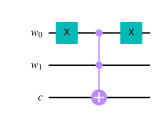

In [30]:
qcirc = QuantumCircuit()
qb_w_reg = QuantumRegister(2, name="w")
qb_c_reg = QuantumRegister(1, name="c")
qcirc.add_register(qb_w_reg, qb_c_reg)
apply_cond_init_number(qcirc, qb_w_reg, qb_c_reg, 3)
qcirc.draw(scale=0.7)

其次是待定格与其它待定格不同。函数 `apply_cond_edges` 的作用是，当两组工作量子比特所表示的值相等时，就作用 $X$ 门路在辅助比特上。其构造思路是，利用 XNOR 运算的可逆性，将第二组量子比特作为临时的辅助比特，储存了它是否与第一组量子比特的数值相等的信息；当受控 $X$ 门作用到辅助比特后，再将第二组量子比特的数值还原回来。

In [31]:
def apply_cond_edges(qcirc, qb_w_reg1, qb_w_reg2, qb_c):
    """
    Ctrl-X gate on control qubit, if working qubits reg1 and reg2 represents the same value
    qcirc: Quantum circuit
    qb_w_reg1, qb_w_reg2: Working qubit registers
    qb_c: Control qubit
    """
    # change reg2 to XNOR(reg1, reg2)
    qcirc.x(qb_w_reg1)
    for qb_1, qb_2 in zip(list(qb_w_reg1), list(qb_w_reg2)):
        qcirc.cx(qb_1, qb_2)
    # qcirc.x(qb_w_reg1)
    qcirc.mcx(qb_w_reg2, qb_c)
    # uncompute XNOR
    # qcirc.x(qb_w_reg1)
    for qb_1, qb_2 in zip(list(qb_w_reg1), list(qb_w_reg2)):
        qcirc.cx(qb_1, qb_2)
    qcirc.x(qb_w_reg1)
    return qcirc

对于两组两个比特之间的数值比较，其线路就如下图所示。

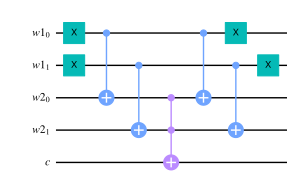

In [32]:
qcirc = QuantumCircuit()
qb_w_reg1 = QuantumRegister(2, name="w1")
qb_w_reg2 = QuantumRegister(2, name="w2")
qb_c_reg = QuantumRegister(1, name="c")
qcirc.add_register(qb_w_reg1, qb_w_reg2, qb_c_reg)
apply_cond_edges(qcirc, qb_w_reg1, qb_w_reg2, qb_c_reg)
qcirc.draw(scale=0.7)

有了这些准备，我们可以对整个 Oracle 门路进行实现。需要注意，Oracle 门路的辅助比特分为三类：

1. 处理与已知数字不同的情况 (程序中记为 $ci$)
2. 处理待定格子相互不同的情况 (程序中记为 $ce$)
3. 用于控制相位 (程序中记为 $out$)

对于当前的 Sudoku 问题，所有的量子线路中所有量子比特都会参与到 Oracle 门路中。这里的 `generate_qubit_registers` 是输入数独问题，给出分配好的线路所需量子比特；`apply_constrains_sudoku` 则是将所有数独的限制条件，通过受控门路应用到量子线路中。

In [33]:
def generate_qubit_registers(puzzle):
    """
    Generate all qubit registers required to solve Sudoku puzzle by Grover algorithms.
    puzzle: Sudoku puzzle instance
    """
    nqubit = get_nqubit(puzzle)
    empty_grids = get_empty_grids(puzzle)
    cond_init_number = get_cond_init_number(puzzle, max_number=2**nqubit)
    cond_edges = get_cond_edges(puzzle)
    qb_w_list = [QuantumRegister(nqubit, name="w" + str(n)) for n in empty_grids.keys()]
    qb_c_init = QuantumRegister(sum([len(i) for i in cond_init_number.values()]), name="ci")
    qb_c_edge = QuantumRegister(sum([len(i) for i in cond_edges.values()]), name="ce")
    qb_out = QuantumRegister(1, name="out")
    return qb_w_list, qb_c_init, qb_c_edge, qb_out

In [34]:
def apply_constrains_sudoku(puzzle, to_gate=True):
    """
    Apply constrains as controled gates for Sudoku puzzle.
    These controled gates combined with multi-ctrl-x gate to qb_out, will give a complete Oracle.
    puzzle: Sudoku puzzle instance
    to_gate: Whether transform Oracle to gate (for visualization)
    """
    nqubit = get_nqubit(puzzle)
    empty_grids = get_empty_grids(puzzle)
    cond_init_number = get_cond_init_number(puzzle, max_number=2**nqubit)
    cond_edges = get_cond_edges(puzzle)
    
    qb_w_list, qb_c_init, qb_c_edge, qb_out = generate_qubit_registers(puzzle)
    
    qcirc = QuantumCircuit()
    qcirc.add_register(*qb_w_list, qb_c_init, qb_c_edge)
    
    n_init = 0
    for n_reg, num_list in cond_init_number.items():
        for num in num_list:
            apply_cond_init_number(qcirc, qb_w_list[n_reg], qb_c_init[n_init], num)
            n_init += 1
    n_edge = 0
    for n_reg1, n_reg2_list in cond_edges.items():
        for n_reg2 in n_reg2_list:
            apply_cond_edges(qcirc, qb_w_list[n_reg1], qb_w_list[n_reg2], qb_c_edge[n_edge])
            n_edge += 1
    if to_gate:
        gate = qcirc.to_gate()
        gate.name = "Ctrl"
        return gate
    else:
        return qcirc

以 Puzzle (1)，将数独的所有限制条件用于量子线路的效果如下所示。下图需要展开代码结果方能显示。

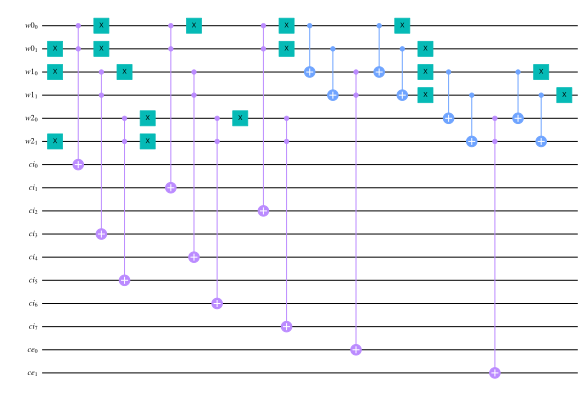

In [35]:
qcirc = apply_constrains_sudoku(puzzle1, to_gate=False)
qcirc.draw(scale=0.5)

但需要注意的是，这并不是完整的 Oracle 门路。要使其成为 Oracle，还需要将所有限制条件总地作用于控制相位的比特 $out$ 中。同时，其余的工作比特 $ci$, $ce$ 需要复归原位；因此还需要将方才的控制线路再作用一次。原则上，再作用一次应该是要取算符的共轭转置；但由于我们使用的无外乎是实空间下的对称的算符，因此这个控制线路的共轭转置就等于它本身。

若将上面的线路记为 $\text{CTRL}$，那么完整的 Oracle 实际上如下述代码的执行结果所示。

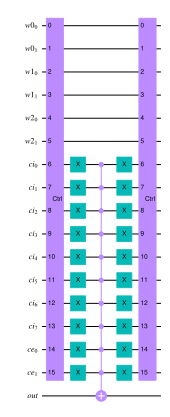

In [36]:
qb_w_list, qb_c_init, qb_c_edge, qb_out = generate_qubit_registers(puzzle1)
qb_w_all = list(itertools.chain(*[qb_w_reg for qb_w_reg in qb_w_list]))
qcirc = QuantumCircuit()
qcirc.add_register(*qb_w_list, qb_c_init, qb_c_edge, qb_out)
ctrl_gate = apply_constrains_sudoku(puzzle1, to_gate=True)

qcirc.append(ctrl_gate, qb_w_all + list(qb_c_init) + list(qb_c_edge))
qcirc.x(list(qb_c_init) + list(qb_c_edge))
qcirc.mcx(list(qb_c_init) + list(qb_c_edge), qb_out)
qcirc.x(list(qb_c_init) + list(qb_c_edge))
qcirc.append(ctrl_gate, qb_w_all + list(qb_c_init) + list(qb_c_edge))

qcirc.draw(scale=0.5)

### 相移增幅算符 $U_s$

相移增幅算符 $U_s = 2 | \psi \rangle \langle \psi | - I$ 是作用于工作比特 $w$ 上的算符。它可以写为下述表达式：

$$
U_s = H^{\otimes r} X^{\otimes r} (MCZ) X^{\otimes r} H^{\otimes r}
$$

其中，上式的 $r$ 为量子比特数。

这里的函数 `generate_diffuser` 就直接参考 [Qiskit 文档](https://qiskit.org/textbook/ch-algorithms/grover.html#3.1-Qiskit-Implementation-) 的实现了。这里的实现代码就折叠起来了。

In [37]:
def generate_diffuser(nqubits, to_gate=True):
    """
    Code from Qiskit document.
    https://qiskit.org/textbook/ch-algorithms/grover.html#3.1-Qiskit-Implementation-
    """
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    if to_gate:
        U_s = qc.to_gate()
        U_s.name = "$U_s$"
        return U_s
    else:
        return qc

### 完整的数独线路

我们现在已经有了 Grover 算法最关键的两个门路：Oracle $O$ 与相移增幅算符 $U_s$ 了。在构建最终的数独线路时，我们还需要注意到

- 需要将工作比特初始化成 $| \psi \rangle = \frac{1}{\sqrt{2^r}} \sum_x^{2^r-1} | x \rangle$ 即均衡叠加态；因此需要先在所有工作比特上加 $H$ 门路。
- 需要将用于控制相位的辅助比特初始化为 $| - \rangle = \frac{1}{\sqrt{2}} \big( | 0 \rangle - | 1 \rangle \big)$，因此需要先引入 $HX$ 两个门路。
- 最后需要将结果测量到传统比特上。
- Oracle 的迭代次数需要用户在 `iteration` 参量中手动指定。

下述的函数 `generate_qcirc_sudoku` 就是最终生成数独问题的量子线路。

In [38]:
def generate_qcirc_sudoku(puzzle, iteration):
    """
    Generate quantum circuit for Sudoku problem
    puzzle: Sudoku puzzle instance
    iteration: Number of Oracles applied in circuit
    """
    qcirc = QuantumCircuit()
    qb_w_list, qb_c_init, qb_c_edge, qb_out = generate_qubit_registers(puzzle)
    qb_w_all = list(itertools.chain(*[qb_w_reg for qb_w_reg in qb_w_list]))
    cb_all = ClassicalRegister(len(qb_w_all), name="cbits")
    qcirc.add_register(*qb_w_list, qb_c_init, qb_c_edge, qb_out, cb_all)

    ctrl_gate = apply_constrains_sudoku(puzzle, to_gate=True)
    diffuser_gate = generate_diffuser(len(qb_w_all))

    qcirc.h(qb_w_all)
    # qcirc.initialize([1, -1]/np.sqrt(2), qb_out)
    qcirc.x(qb_out)
    qcirc.h(qb_out)
    qcirc.barrier()
    for _ in range(iteration):
        qcirc.append(ctrl_gate, qb_w_all + list(qb_c_init) + list(qb_c_edge))
        qcirc.x(list(qb_c_init) + list(qb_c_edge))
        qcirc.mct(list(qb_c_init) + list(qb_c_edge), qb_out)
        qcirc.x(list(qb_c_init) + list(qb_c_edge))
        qcirc.append(ctrl_gate, qb_w_all + list(qb_c_init) + list(qb_c_edge))
        qcirc.append(diffuser_gate, qb_w_all)
        qcirc.barrier()
    qcirc.measure(qb_w_all, cb_all)
    return qcirc

以 Puzzle (1) 为例，如果 Oracle 执行三次，则其线路可以表示如下：

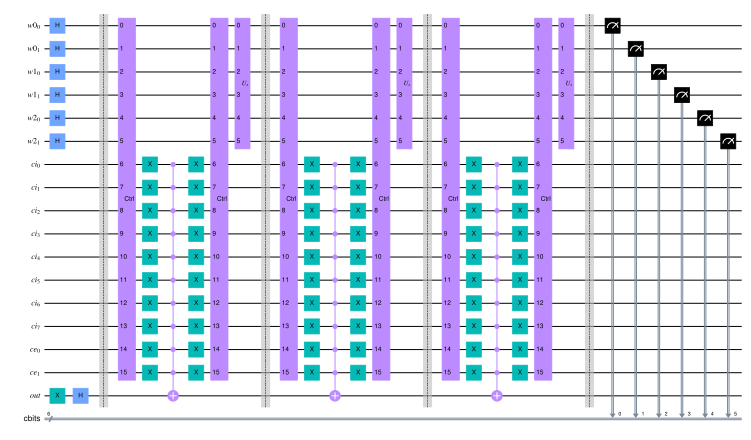

In [39]:
qcirc = generate_qcirc_sudoku(puzzle1, 3)
qcirc.draw(scale=0.5, fold=-1)

## 数独问题的解

### 对 Puzzle (1) 的讨论

我们知道 Puzzle (1) 的解有两种：$(V_0, V_1, V_2)$ 的可能取值是 $(1, 2, 1)$。

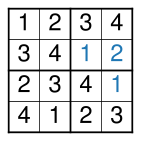

In [40]:
fig, ax = plt.subplots(figsize=(2.3, 2.3))
plot_puzzle_2x2(Sudoku.decode("1234341223414123"), ax, original=puzzle1)

Oracle 执行的次数是需要用户手动输入的。那么输入多少合适呢？

我们现在必须基于已经知道数独解的数量 $M$ 的前提讨论问题。对于 Puzzle (1)，我们知道解的数量 $M$ 是 1。而总共又有 3 个待定格子，每个格子都可能取 1~4 任何一个数；因此求解的搜索空间大小 $N = 4^3 = 64$。

我们先前已经展示过，若要使求得正解的概率最大，那么 Oracle 迭代次数

$$
k = \frac{\pi}{4 \arcsin \sqrt{M / N}} - \frac{1}{2}
$$

在当前的例子中，$k \simeq 6$。

In [41]:
np.pi / 4 / np.arcsin(np.sqrt(1 / 64)) - 1 / 2

5.766749819872207

我们不妨看一下，依据量子线路执行后的本征态，6 次迭代后正确求得解 $(V_0, V_1, V_2) = (0, 1, 2)$ 的概率是

In [42]:
qcirc = generate_qcirc_sudoku(puzzle1, 6)
prob_dict = get_result_prob_by_statevector(qcirc, qcirc.qubits[:2 * 3])
{tuple(decode_cbits_sudoku(key, 2)): val for key, val in prob_dict.items()}

{(1, 2, 1): 0.9965856807865088}

我们还可以作正确率关于迭代次数的关系图：

In [43]:
success_list = []
for iteration in range(0, 12):
    qcirc = generate_qcirc_sudoku(puzzle1, iteration)
    prob_dict = get_result_prob_by_statevector(qcirc, qcirc.qubits[:2 * 3], tol=0)
    prob_dict = {tuple(decode_cbits_sudoku(key, 2)): val for key, val in prob_dict.items()}
    success_list.append(prob_dict[(1, 2, 1)])

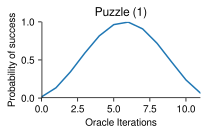

In [44]:
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(range(12), success_list)
ax.set_xlim(0, 11); ax.set_ylim(0, 1)
ax.plot([0, 0], [0, 1], color="black"); ax.plot([0, 11], [0, 0], color="black")
ax.set_xlabel("Oracle Iterations"); ax.set_ylabel("Probability of success"); ax.set_title("Puzzle (1)")
fig.tight_layout()

我们就会发现，能正确找到问题的概率随着 Oracle 迭代次数大致呈正弦函数平方的关系；并非迭代次数越多越好。因此，在不知道问题的解的数量时，应用 Oracle 求解数独问题不一定是非常好的策略；这是 Grover 算法的缺点之一。其中一种可能的解决办法是，将求取解的数量 $M$ 转化为循环群的求阶问题。

并且从上面的讨论中，我们注意到，Grover 算法寻找解的数量，如果不需要考虑量子线路的误差，那么可以以近乎 100% 的概率得到正确结果 (特比是当解空间 $N$ 非常大时)。这可能与我们习惯上认知的量子力学不一样 (比如 [薛定谔的猫](https://zh.moegirl.org.cn/index.php?title=%E8%96%9B%E5%AE%9A%E8%B0%94%E7%9A%84%E7%8C%AB&redirect=no))，是几乎不存在不确定性的，或者说不确定性是可以近乎任意精度地控制在非常低的范围。

我认为，这种情况下，可以称这种量子算法不具有明显的不确定性。另一种近乎不存在不确定性的算法是 Shor 分解质因数算法。但许多基于量子计算的优化算法 (包括化学中提及的 VQE-UCCSD 问题) 则是有较强不确定性，需要依靠大量测量得到相对准确的算符观测期望值。

### 对 Puzzle 2 的讨论

我们知道 Puzzle (2) 的解有两种：$(V_0, V_1, V_2, V_3)$ 的可能取值是 $(1, 2, 2, 1)$ 与 $(2, 1, 1, 2)$。

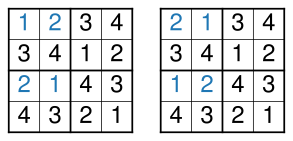

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(5, 2.3))
plot_puzzle_2x2(Sudoku.decode("1234341221434321"), axs[0], original=puzzle2)
plot_puzzle_2x2(Sudoku.decode("2134341212434321"), axs[1], original=puzzle2)

对于该问题，解空间的大小是 $N = 4^4 = 256$、可能解的数量是 $M = 2$。由此，可以推算得到需要运行的 Oracle 次数是 $k \sim 8$ 次：

In [46]:
np.pi / 4 / np.arcsin(np.sqrt(2 / 256)) - 1 / 2

8.374170154616117

对于 Puzzle (2)，以我们的算法进行线路构造时，需要的量子比特数会比较多，达到 21 个。在这种情况下，使用在一般的计算机上使用 statevector 精确地模拟运行结果会比较耗费资源。我们这里就模拟地进行 1000 次测量，并将比特测量的情况解码到数独问题的解：

In [47]:
qcirc = generate_qcirc_sudoku(puzzle2, 8)
prob_dict = get_result_prob_by_shots(qcirc, shots=1000)
{tuple(decode_cbits_sudoku(key, 2)): val for key, val in prob_dict.items()}

{(2, 3, 2, 1): 0.001,
 (3, 4, 1, 3): 0.001,
 (3, 3, 4, 4): 0.001,
 (4, 1, 3, 3): 0.001,
 (3, 3, 2, 2): 0.001,
 (1, 3, 4, 3): 0.001,
 (4, 2, 3, 2): 0.001,
 (2, 3, 2, 3): 0.001,
 (1, 3, 3, 2): 0.001,
 (3, 4, 1, 4): 0.001,
 (1, 2, 2, 1): 0.481,
 (2, 1, 1, 2): 0.509}

可以看到，在大量采样时还是会有大约 0.5% 的概率得到错误的解，但这个概率已经非常小了。

### 挑战？3 阶数独简单情形的求解

在最后一个例子中，我们引入下述 $n = 3$ 的三阶矩阵 Puzzle (3)，并使用我们的量子线路尝试进行求解。

> 这个问题是不是太简单了亿点 hhhh

Text(0.5, 0, 'Puzzle (3)')

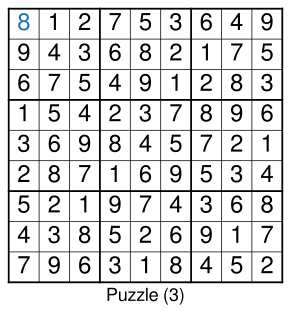

In [48]:
puzzle3 = sudokutools.sudoku.Sudoku.decode("012753649943682175675491283154237896369845721287169534521974368438526917796318452")
sudokutools.solve.init_candidates(puzzle3)
solution3 = sudokutools.sudoku.Sudoku.decode("812753649943682175675491283154237896369845721287169534521974368438526917796318452")

fig, ax = plt.subplots(figsize=(5, 5))
plot_puzzle_3x3(solution3, ax=ax, original=puzzle3)
ax.set_xlabel("Puzzle (3)", fontsize=18)

但是在这个问题的求解过程中，我们需要消耗大量的辅助量子比特。唯一的待定格子由于与 1, 2, 3, 4, 5, 6, 7, 9 都不相同，因此需要 8 个辅助量子比特用于实现待定格不能与已知数相等的条件。

但除此之外，注意到对每个取值范围是 1~9 数字进行二进制编码，耗费的量子比特是 4 个；可是，待定格子也不能取 10, 11, 12, 13, 14, 15, 16。我们在当前的程序中，使用了最简单的办法，即将这些数字一并列入限制条件。这样一来，这个待定格子就需要额外多 7 个辅助量子比特了。这样一算下来，整个线路总共就需要 20 个量子比特。

In [49]:
qcirc = generate_qcirc_sudoku(puzzle3, 3)
qcirc.num_qubits

20

20 个量子比特基本上已经是目前在经典计算机上，实现量子模拟的极限了 (内存受限)。因此，对于 3 阶数独，以我们目前的算法实现，在模拟机上只能解决 1 个待定格子问题。这确实可谓是杀鸡用 <del>牛刀</del> 氦闪了。

不过我们可以验证一下，我们的程序确实能给出正确的答案，即待定格子的值是 8。

此时的解数量 $M = 1$、解空间是 $N = 16$，对应了 $k \simeq 3$ 的情况。我们能以大约 95% 的概率获得正确解。

In [50]:
qcirc = generate_qcirc_sudoku(puzzle3, 3)
prob_dict = get_result_prob_by_shots(qcirc, shots=1000)
{tuple(decode_cbits_sudoku(key, 4)): val for key, val in prob_dict.items()}

{(16,): 0.002,
 (2,): 0.003,
 (12,): 0.004,
 (8,): 0.962,
 (4,): 0.003,
 (13,): 0.002,
 (9,): 0.002,
 (3,): 0.002,
 (1,): 0.003,
 (14,): 0.004,
 (11,): 0.003,
 (15,): 0.001,
 (10,): 0.004,
 (6,): 0.002,
 (5,): 0.003}

## 复杂度分析与杂谈

### 算法所需的量子比特数

对于数独算法，其所需要的量子比特数其实还是不少的。

- 编码一个数字所需要的比特数是 $n_\mathrm{qubit} = \lceil \log_2(n^2) \rceil \sim 2 \log_2 n$；
- 对于待定格子数是 $n_\mathrm{empty}$ 的 $n$ 阶数独，编码这些待定格子所需要的比特数就达到 $n_\mathrm{empty} \lceil \log_2(n^2) \rceil \sim 2 n_\mathrm{empty} \log_2 n$；
- 用于待定格子不能与已知数字等值的规则的辅助比特，需要不多于 $n_\mathrm{empty} 2^{\lceil \log_2(n^2) \rceil} \sim n_\mathrm{empty} n^2$ 个；其中，$2^{\lceil \log_2(n^2) \rceil}$ 是量子比特所有可能表示的数值，它大约等于数独棋盘的横或纵格子数 $n^2$；
- 用于待定格子之间不能等值的规则的辅助比特，需要不多于 $\frac{1}{2} n_\mathrm{empty} n_\mathrm{empty}$ 或 $3 n^2 n_\mathrm{empty} / 2$ 个；
    - 前者所代表的是 $n_\mathrm{empty}$ 比较小的情况，最坏时所有格子对都或者同行、或者同列、或者同宫；
    - 后者所代表的是 $n_\mathrm{empty}$ 比价大的情况，最坏时单个待定格子所处的所有同行、同列、同宫的格子也都是待定的；
- 以及最后有一个用于给出相位变化的辅助比特。

但需要指出，用于待定格子不能与已知数字等值的规则的辅助比特，是有可能省略的。以 2 阶数独为例，正常情况下，我们会将一个待定格子所对应的量子比特初始化为均衡叠加态

$$
| \psi \rangle = \frac{1}{\sqrt{4}} \big( | 1 \rangle + | 2 \rangle + | 3 \rangle + | 4 \rangle \big)
$$

但如果这个待定格子只可能取 1, 2 值呢 (就像 Puzzle (1) 中的 $V_1$ 的情况)？那么不如干脆将 $| 3 \rangle + | 4 \rangle$ 剔除出均衡叠加态的初始态，而初始化为

$$
| \psi \rangle = \frac{1}{\sqrt{2}} \big( | 1 \rangle + | 2 \rangle \big)
$$

这种做法就将与已知数字不等值的规则，从利用额外的 $n^2 n_\mathrm{empty}$ 个辅助比特实现，转化到量子态的初始化的问题。这也并非是毫无代价的：它要求使用大约 $\log_2^2 (n^2) n^2$ 个单、双比特门[^Long-Sun.PRA.2001]。不过这个代价相对于 Oracle 的实现，还是非常能接受的。单纯从这点上，我们的算法实现上也还有很大的改进空间。

[^Long-Sun.PRA.2001]: Long, G.-L.; Sun, Y. Efficient Scheme for Initializing a Quantum Register with an Arbitrary Superposed State. *Phys. Rev. A* **2001**, *64* (1), 014303. doi: [10.1103/PhysRevA.64.014303](https://doi.org/10.1103/PhysRevA.64.014303).

### 问题：8192 个量子比特可以解多少阶数独？

在电影《流浪地球 2》中，功能强大的 550W 型量子计算机的“量子体积”是 8192。这种计算机不仅可以高效地调度月球上大量工程的建设，而且还可以进行长时间的虚拟智能生命演化。从我在写这文档的当前，以最强大的传统超级计算机的算力来看，这都是相当难以企及的 (当然也可能只是软件对硬件的实现效率、或人工智能网络的复杂程度还有待提升)。

我们先不管 **量子体积** 真正的定义是什么。就不妨假设 550W 型量子计算机有 8192 个量子比特，且量子噪声为零。

我们对这个问题作进一步框定。

- 假设我们可以任意地对量子态进行初始化 (即不需要考虑待定格子不能与已知数字等值的规则，所需要占用的辅助比特)；
- 数独的盘面上有一半的待定格 ($n_\mathrm{empty} \simeq n^4 / 2$)。

在这个限制条件下，我们会估计对于每个待定格子平均下来，与其在同行、同列或同宫的待定格子数大约是 $3 n^2 / 2$ 个。因此，整个问题大约需要的量子比特数是

$$
2 n_\mathrm{empty} \log_2 n + \frac{1}{2} n_\mathrm{empty} \times \frac{3 n^2}{2}
\simeq
n^4 \log_2 n + \frac{3 n^6}{8}
$$

如果上面的估计没有错的话，依 Grover 算法，8192 个量子比特也只能解 5 阶数独而已 (实际消耗大约 7310 个量子比特)。这棋盘上还只是一半的格子被镂空了；但不妨回想一下，你所遇到过的现实的三阶数独问题，有哪一个只把一半镂空的？

:::{warning}

**结论** 五阶数独求解的难度等同于智能生命的演化 (doge)
:::

当然，之所以得到这么离谱的结论，也可以归结为当前的 Grover 算法或许没有高效地实现。不过即使不需要辅助比特，光是 $n^4 \log_2 n$ 的工作比特数，这也只够解 7 阶数独。

> 也可能只是眼高手低的我，小看了数独问题的难度。

In [51]:
n_qubit_sudoku_asymptotic = lambda n: int(n**4 * np.log2(n) + 3 * n**6 / 8)
print("Order   Asymptotic")
for n in range(2, 8):
    print("{:3} {:12d}".format(n, n_qubit_sudoku_asymptotic(n)))

Order   Asymptotic
  2           40
  3          401
  4         2048
  5         7310
  6        20846
  7        50858


### 线路复杂度

整个量子线路，基本上就是重复执行 Oracle 门路与相移增幅算符 $U_s$。Oracle 门路又分为为了应用数独限制条件而设计的对辅助比特的控制门路、以及对多个辅助比特实现受控非门的门路。

先考虑 Oracle 门路。每个数独限制条件的实现都不困难：

- 对于待定格子不能与已知数字等值的规则，它使用了若干个可以并行的非门、以及一个多控非门。考虑到整个线路的冗余辅助比特非常多，因此应用于 $\lceil \log_2 (n^2) \rceil$ 个比特的多控非门，可以在 $O(\log_2 n)$ 的双比特门路下实现[^Barenco-Weinfurter.PRA.1995]。

- 对于待定格子之间不能等值的规则，除了多控非门外，还涉及到一些两比特间的 XNOT 门路 (使用非门和受控非门各一个实现)；这也是 $O(\log_2 n)$ 的复杂度。

因此，总地来说，既然规则数量在 $O(n^6)$ 级别，那么单个 Oracle 门路所需要的单、双比特数就在 $O(n^6 \log_2 n)$ 级别上。

[^Barenco-Weinfurter.PRA.1995]: Barenco, A.; Bennett, C. H.; Cleve, R.; DiVincenzo, D. P.; Margolus, N.; Shor, P.; Sleator, T.; Smolin, J. A.; Weinfurter, H. Elementary Gates for Quantum Computation. Phys. Rev. A 1995, 52 (5), 3457–3467. doi: [10.1103/PhysRevA.52.3457](https://doi.org/10.1103/PhysRevA.52.3457).

对于相移增幅算符 $U_s$，它最复杂的部分是作用在大约 $2 n_\mathrm{empty} \log_2 n$ 个工作比特上的多控非门、考虑到 $n_\mathrm{empty} < n^4$，那么相移增幅算符 $U_s$ 所需要的单、双比特数在 $O(n^5 \log_2 n)$ 级别上。

事实上，对于 Oracle 门路，会有许多算符是相互对易的；因此，Oracle 门路预期可以大幅利用并行优势。我猜并行的提升在 $n^2$ 倍左右。因此，单次 Grover 过程 (一次 Oracle 门路接一次相移增幅算符 $U_s$) 的总复杂度是 $O(n^5 \log_2 n)$ 左右。

----------

但 Grover 算法最大的困难，还在于需要迭代执行 Oracle 门路的次数。事实上，解空间大小

$$
N = 2^{n_\mathrm{empty} \lceil \log_2 (n^2) \rceil} \simeq n^{2 n_\mathrm{empty}}
$$

如果我们不考虑解的数量 $M$，那么 Orcale 门路运行次数的估计就是

$$
k \simeq \frac{\pi}{4} \sqrt{\frac{N}{M}} - \frac{1}{2} \sim O(n^{n_\mathrm{empty}})
$$

所以实际上，Grover 算法总的复杂度会在 $O(n^{n_\mathrm{empty}} n^5 \log_2 n)$ 左右。它仍然无法成为多项式的计算量。同时要注意到，Grover 算法的线路复杂度也是指数级别的；这对于含有噪声的量子计算机而言，不一定是好事。

### 乱谈一波？

> 这副标题就很有做计算化学的风范~ (假装斯文)
>
> 不过作为外行，没有近期文献的阅读经历，以下言论对得起乱谈二字。

这份文档是在前几天的一次聚会上，听到同学提及，如果将数独的所有数字全都编码为二进制或者布尔值，那么是否有办法在这种新的、不太能直观理解的结构下，找到更快速的解数独的方法。

我后来回去一想，觉得数独是一个搜索问题；同时如果能将数独编码为二进制，那么它就与量子比特所表示的态无异了。再随后一找，果然数独被认为是一种 Grover 算法的典型应用范例。

但现在的不少说明文档，于我而言总觉得有些缺憾。Qiskit 老版本文档[^qiskit_grover]详细地介绍了 Grover 算法；新版本[^qiskit_grover_new]代码更是有对 3-SAT 问题的讨论。不过对数独问题，老版本文档只介绍了 1 阶数独的求解；对于更高阶的数独，没有提供 Orcale 的实现 (但从本文档来看，也不可谓很难)。Microsoft 的代码示例[^microsoft_sudoku_example]给出了更高阶数独的解法，但一来不能说有详细的文档、二来 Orcale 算法似乎是直接使用上色问题而不是从头实现 (尽管对于 API 使用者来说这样的代码更友好)、三来不是 Python (我已经不会编译语言了 hhh)。

尽管说从头写一份文档其实也不过抄来抄去 (鄙校编教材中招 \`•ω•´)，但我自己还是挺喜欢这么搞的。

[^qiskit_grover_new]: [Qiskit (beta): Grover's search algorithm](https://learn.qiskit.org/course/introduction/grovers-search-algorithm)

[^microsoft_sudoku_example]: [Microsoft: Solving Sudoku using Grover's Algorithm](https://learn.microsoft.com/en-us/samples/microsoft/quantum/solving-sudoku-using-grovers-algorithm/)

-------

$n$ 阶数独已经被证明是 NP-complete 问题了[^Yato-Seta]。而我印象里，现在一般并未认为经典计算的 NP 问题是可以转化为量子计算的 P (BQP) 问题；甚至很有可能，经典计算的 NP 问题在量子计算下也是 NP (QMA) 的。这也就意味着，很多时候，恐怕无法指望量子计算极大程度地改善经典计算近乎于无法解决的问题。拿 $n$ 阶数独来说，恐怕它即使是在量子计算下，也大概率是 NP (QMA) 的。

[^Yato-Seta]: Yato, T. ; Seta, T. Complexity and completeness of finding another solution and its application to puzzles. *IEICE Transactions on Fundamentals of Electronics, Communications and Computer Sciences*, **2003**, *E86-A* (5), 1052–1060.

但也不能太悲观。

- 一方面，Grover 相对于暴力搜索算法而言，其效率提升是平方级的。
- 另一方面，在经典计算机中仍然存在一些无法被证明是 NP-complete，但实现上暂未找到 P 实现算法的问题 (譬如质因数分解问题)；在这些问题上，量子计算有很大的优势。

但又不能太乐观。

- 平方级的效率提升很大，但若搜索空间 $N$ 没有大到一定程度，暴力搜索完全可能因为经典计算机处理芯片 (CPU, GPU 等) 的处理速度比量子计算机的算一个门路快 $\sqrt{N}$ 倍，而使得量子计算机毫无优势可言。
- 平方级的效率提升，也可以通过改进经典计算机上的算法实现。见 [Qiskit 新文档](https://learn.qiskit.org/course/introduction/grovers-search-algorithm) 关于 Grover 算法与 3-SAT 问题的讨论；对 3-SAT 算法的一些改进就可以在复杂度上超越 Grover 算法。
- 数独已经被证明与 3-SAT 结构相似，是 NP-complete 的。从这一点上，也不能简单地将数独与素因数分解问题作类比，认为可能在多项式线路复杂度下解决问题；毕竟素因数分解似乎没有被证明 NP-complete。似乎现在没有 NP-complete 但 BQP 的先例？

但还是不能太悲观。

- 质因数分解算法 (Shor) 之所以能在多项式复杂度下解决问题，一部分原因是幂次计算 ($n^m \ \mathrm{mod} \ r$) 在量子计算机下是对数时间下 (在 $\log_2 n$ 或 $\log_2 m$ 级别下) 可实现的。

    尽管幂次在经典计算机下也是对数级别可实现的，量子计算机并没有什么特别。但我想说的意思是，我们不妨回顾到，对于 QCQI[^QCQI_grover] 6.3 节介绍的量子计数问题 (求出搜索问题的解数量 $M$)，如果将 Grover 门路换成幂次计算的门路，那么就与 Shor 算法完全等价 (同样是相位估计算法)。Shor 算法可以看成是循环群求阶问题，也可以看成是搜索问题的量子计数问题。但 Shor 算法就与数独问题不同，不需要在 $O(\sqrt{N})$ 代价而只需要 $O(\log^{4} N)$ 实现 (也可能是 $O(\log \log N \log^3 N)$？总之是对数下多项式的)，原因就是 Grover 门路的幂次计算 $G^n$ 对应到质因数分解问题，只需要 $O(\mathrm{poly}(\log n))$ 时间；但数独问题的 $G^n$，恐怕现在还没有找到一种比 $O(n)$ 代价更低的实现方式。

    我现在也还不清楚，数独问题的 Grover 算符的幂次，是否存在一种特殊的数学结构，使得 $G^n$ 的计算也可以在对数时间 $O(\mathrm{poly}(\log n))$ 完成。(但如果真有人发现新的数学结构，那应该可以冲一波大奖了？)

- 也如 [Qiskit 新文档](https://learn.qiskit.org/course/introduction/grovers-search-algorithm) 末尾所言，量子和经典算法的混合，或许会有新的可能性产生。
    
注：在 EPL 2020[^Pal-Panigrahi.EPL.2020]中，作者应该是使用了量子态删除的方式实现了量子线路的数独实现，且为经典-量子混合方法，并表明有 $O(\log (k))$ 级别的提速。他们使用的量子比特数，按我们的文档记号，是 $2 n^4 \log_2 n$ 的，即非常精简的。我可能还没能完全理解他们的文章。

[^Pal-Panigrahi.EPL.2020]: Pal, A.; Chandra, S.; Mongia, V.; Behera, B. K.; Panigrahi, P. K. Solving Sudoku Game Using a Hybrid Classical-Quantum Algorithm. *Europhysics Letters* **2020**, *128* (4), 40007. doi: [10.1209/0295-5075/128/40007](https://doi.org/10.1209/0295-5075/128/40007).

------

如文档开头所述，各种平台[^sudokuwiki]或软件[^SunnieShine]其实已经对数独问题有很深入的研究了。我直到写这篇文档时，才发现原来数独问题可以有如此多的求解策略。不得不说我以前确实小看了数独问题。

但这些策略在 3 阶数独并不见得可以加速传统计算机上的求解。现在的数独求解，最快的程序之一可能是 tdoku[^t-dillon_tdoku]。以我的能力暂时还不能完全理解，但我估计它大概可以看作是应用了非常简单的规则，同时考虑到 CPU 的架构，实现的指令集优化的 DFS 代码。

即使没有将数独从指数复杂度降到多项式复杂度，但经典计算机对这类问题的求解能力，还是相当恐怖的。而且极少的规则就可以大幅减少搜索空间的数量 $N$，从而事实上也会计算复杂度。这个降幅，或许未必比 $\sqrt{N}$ 小。

[^t-dillon_tdoku]: [Github: t-dillon/tdoku](https://github.com/t-dillon/tdoku)

## 程序版本信息

In [ ]:
print("=== Version Info ===")
print("{:15}: {}".format("Python", sys.version.split()[0]))
print("{:15}: {}".format("Qiskit", qiskit.__version__))
print("{:15}: {}".format("NumPy", np.__version__))
print("{:15}: {}".format("sudokutools", sudokutools.__version__))
print("{:15}: {}".format("Matplotlib", mpl.__version__))

=== Version Info ===
Python         : 3.8.13
Qiskit         : 0.23.1
NumPy          : 1.23.5
sudokutools    : 0.4.0
Matplotlib     : 3.5.1
